In [1]:
from pathlib import Path

from arcgis.features import GeoAccessor
from arcgis.gis import GIS
from arcgis.geoenrichment import Country
import arcpy
import pandas as pd
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler

import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
dir_prj = Path.cwd().parent
dir_data = dir_prj/'data'
dir_int = dir_data/'interim'
gdb_int = dir_int/'interim.gdb'

arcpy.env.overwriteOutput = True

In [56]:
aoi_name = 'cbsa_seattle'
aoi_fc = gdb_int/aoi_name
id_col = 'IDField'
kmeans_fc = gdb_int/f'{aoi_fc.stem}_kmeans'

enrich_fc = gdb_int/'block_groups_enrich'

overwrite_enrich = True

In [51]:
ev = Country('usa', gis=GIS('pro')).enrich_variables

sv = ev[
    (ev.name.str.endswith('CY'))
    | (
        (ev.alias.str.contains('ACS'))
        & (~ev.alias.str.contains('\sMOE\s'))
       )
].drop_duplicates('name').reset_index(drop=True)

sv.info()

e_str = ';'.join(sv.enrich_name)

print(f'{e_str[:120]}...')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2828 entries, 0 to 2827
Data columns (total 5 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   name               2828 non-null   object
 1   alias              2828 non-null   object
 2   data_collection    2828 non-null   object
 3   enrich_name        2828 non-null   object
 4   enrich_field_name  2828 non-null   object
dtypes: object(5)
memory usage: 110.6+ KB
AgeDependency.CHILD_CY;AgeDependency.WORKAGE_CY;AgeDependency.SENIOR_CY;AgeDependency.CHLDDEP_CY;AgeDependency.AGEDEP_CY...


In [57]:
if not arcpy.Exists(enrich_fc) or overwrite_enrich:
    
    bg_fc = arcpy.ba.GenerateGeographiesFromOverlay(
        geography_level="US.BlockGroups", 
        in_features=str(aoi_fc), 
        id_field=id_col,
        out_feature_class='memory/bg', 
        overlap_type="INTERSECT", 
        ratios="AREA_ONLY"
    )[0]
    
bg_fc

'memory\\bg'

In [60]:
bg_lyr = arcpy.management.MakeFeatureLayer(bg_fc)[0]
arcpy.management.SelectLayerByAttribute(bg_lyr, where_clause='Area > 0.5')
arcpy.management.DeleteFeatures(bg_lyr)

<Result 'bg_Layer4'>

In [54]:
bg_lyr = arcpy.management.MakeFeatureLayer(bg_fc)[0]
    arcpy.management.SelectLayerByAttribute(bg_lyr, where_clause='Area > 0.5')
    arcpy.management.DeleteFeatures(bg_lyr)

    bg_std_fc = arcpy.ba.StandardGeographyTA(
        geography_level="US.BlockGroups", 
        out_feature_class=r"memory/bg_std", 
        input_type="TABLE", 
        in_ids_table=bg_fc, 
        geography_key_field="ID"
    )[0]

    arcpy.ba.EnrichLayer(str(bg_fc), out_feature_class=str(enrich_fc), variables=enrich_variables)

SyntaxError: 'break' outside loop (<ipython-input-54-c21c2a1776d9>, line 15)

In [26]:
fld_lst = [f.name.lower() for f in arcpy.ListFields(str(enrich_fc))]

analysis_vars = list(ev[ev.enrich_field_name.str.lower().isin(fld_lst)].drop_duplicates('name').enrich_field_name)

print(f'{len(analysis_vars):,}')

3,572


In [27]:
e_df = pd.DataFrame([r for r in arcpy.da.SearchCursor(str(enrich_fc), analysis_vars)], columns=analysis_vars)

e_df.info()
e_df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2480 entries, 0 to 2479
Columns: 3572 entries, AgeDependency_CHILD_CY to yearmovedin_RELOWNER
dtypes: float64(3572)
memory usage: 67.6 MB


,AgeDependency_CHILD_CY,AgeDependency_WORKAGE_CY,AgeDependency_SENIOR_CY,AgeDependency_CHLDDEP_CY,AgeDependency_AGEDEP_CY,AgeDependency_SENRDEP_CY,homevalue_ACSVAL0,homevalue_MOEVAL0,homevalue_RELVAL0,homevalue_ACSVAL10K,...,yearmovedin_ACSRMV1990,yearmovedin_MOERMV1990,yearmovedin_RELRMV1990,yearmovedin_ACSRMV1989,yearmovedin_MOERMV1989,yearmovedin_RELRMV1989,yearmovedin_ACSMEDYRMV,yearmovedin_MOEMEDYRMV,yearmovedin_RELMEDYRMV,yearmovedin_RELOWNER
0,504.0,1128.0,137.0,44.7,56.8,12.1,0.0,12.0,0.0,0.0,...,9.0,15.0,3.0,0.0,12.0,0.0,2010.0,NaN,3.0,1.0
1,440.0,1079.0,143.0,40.8,54.0,13.3,19.0,31.0,3.0,0.0,...,19.0,31.0,3.0,0.0,12.0,0.0,2009.0,NaN,3.0,2.0
2,357.0,931.0,221.0,38.3,62.1,23.7,0.0,12.0,0.0,0.0,...,0.0,12.0,0.0,0.0,12.0,0.0,2007.0,NaN,3.0,2.0
3,378.0,1090.0,192.0,34.7,52.3,17.6,31.0,51.0,3.0,0.0,...,0.0,12.0,0.0,0.0,12.0,0.0,2012.0,NaN,3.0,2.0
4,354.0,803.0,172.0,44.1,65.5,21.4,34.0,37.0,3.0,11.0,...,24.0,38.0,3.0,0.0,12.0,0.0,2011.0,NaN,3.0,2.0


In [28]:
na_cols = e_df.isna().any()
na_cols = na_cols[na_cols].index.values

na_df = ev[ev.enrich_field_name.isin(na_cols)].reset_index(drop=True)

print(len(na_df.index))

70


In [29]:
e_df.dropna(axis=1, inplace=True)

e_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2480 entries, 0 to 2479
Columns: 3502 entries, AgeDependency_CHILD_CY to yearmovedin_RELOWNER
dtypes: float64(3502)
memory usage: 66.3 MB


In [30]:
sclr = MinMaxScaler()

scl_arr = sclr.fit_transform(e_df)

In [45]:
pca = PCA()

pca.fit(scl_arr)

pca_min_variance = 0.95

cv = pd.Series(pca.explained_variance_ratio_.cumsum())

n_cmpnts = cv[cv > pca_min_variance].index.min() + 1

n_cmpnts

618

In [32]:
pca_sel = PCA(n_components=n_cmpnts)

cmpnts = pca_sel.fit_transform(scl_arr)

D:\Anaconda3\envs\arcgis\lib\site-packages\sklearn\cluster\_kmeans.py:882: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  f"KMeans is known to have a memory leak on Windows "


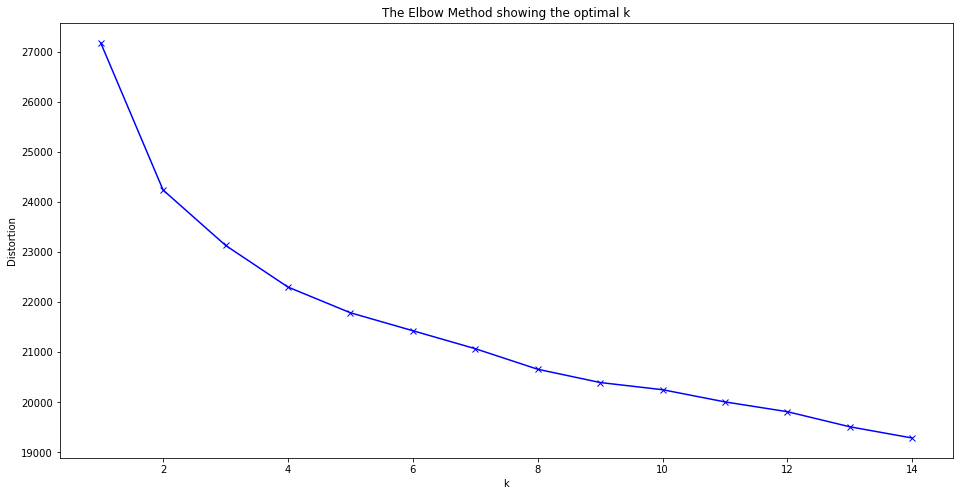

In [16]:
distortions = []

K = range(1, 15)

for k in K:
    km = KMeans(n_clusters=k)
    km.fit(cmpnts)
    distortions.append(km.inertia_)
    
plt.figure(figsize=(16,8))
plt.plot(K, distortions, 'bx-')
plt.xlabel('k')
plt.ylabel('Distortion')
plt.title('The Elbow Method showing the optimal k')
plt.show()

In [20]:
def get_kmeans(cluster_count):
    
    km = KMeans(n_clusters=cluster_count, random_state=42)

    km.fit_transform(cmpnts)

    bg_df = GeoAccessor.from_featureclass(str(enrich_fc), fields=['ID']).rename(columns={'ID': 'id'}).set_index('id').spatial.set_geometry('SHAPE', inplace=False)
    bg_df.insert(0, 'kmeans_cluster', km.labels_)

    km_fc = bg_df.spatial.to_featureclass(gdb_int/f'{aoi_name}_block_group_kmeans_{cluster_count:02d}')
    
    print(f'Created {km_fc}')

    return km_fc

for k in range(2, 5):
    get_kmeans(k)

Created D:\projects\arcgis-demographic-clustering\data\interim\interim.gdb\thurston_county_block_group_kmeans_02
Created D:\projects\arcgis-demographic-clustering\data\interim\interim.gdb\thurston_county_block_group_kmeans_03
Created D:\projects\arcgis-demographic-clustering\data\interim\interim.gdb\thurston_county_block_group_kmeans_04
